# Import

In [1]:
import howiml.core as mlModule

Using TensorFlow backend.


# Define metadata and provide file path to .csv file

In [2]:
model = 'A'

# File path to dataset .csv file
filename = "../master-thesis-db/datasets/D/dataC.csv"

# List of columns on form ['name', 'description', 'unit']
columns = [
    ['20TT001', 'Process Inlet Temperature', 'Degrees'],
    ['20PT001', 'Process Inlet Pressure', 'Bar'],
    ['20FT001', 'Process Flow Rate', 'kg/hour'],
    ['20TT002', 'Process Outlet Temperature', 'Degrees'],
    ['20PDT001', 'Process Pressure Difference', 'Bar'],
    ['50TT001', 'Coolant Inlet Temperature', 'Degrees'],
    ['50PT001', 'Coolant Inlet Pressure', 'Bar'],
    ['50FT001', 'Coolant Flow Rate', 'kg/hour'],
    ['50TT002', 'Coolant Outlet Temperature', 'Degrees'],
    ['50PDT001', 'Coolant Pressure Difference', 'Bar'],
    ['50TV001', 'Coolant Valve Opening', '%'],
]

# List of column names to ignore completely
irrelevantColumns = [
    '20PT001',
    '50PT001',
    '50FT001',
    '50PDT001',
    '50TV001',
]

# List of column names used a targets
targetColumns = [
    '50TT002',
    '20PDT001',
]

# List of training periods on form ['start', 'end']
traintime = [
    ["2020-01-01 00:00:00", "2020-03-20 00:00:00"],
]

# Testing period, recommended: entire dataset
testtime = [
    "2020-01-01 00:00:00",
    "2020-08-01 00:00:00"
]

# Data preprocessing

In [3]:
relevantColumns, columnDescriptions, columnUnits, columnNames, df = mlModule.initDataframe(filename, columns, irrelevantColumns)
df_train, df_test = mlModule.getTestTrainSplit(df, traintime, testtime)
X_train, y_train, X_test, y_test = mlModule.getFeatureTargetSplit(df_train, df_test, targetColumns)

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 20PDT001 - Process Pressure Difference
Col. 4 : 50TT001 - Coolant Inlet Temperature
Col. 5 : 50TT002 - Coolant Outlet Temperature

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00
Found 726 rows



# Define machine learning models

In [4]:
mlp = mlModule.MLP('MLP 1x128 d0.2 mod'+model, X_train, y_train, layers=[128], dropout=0.2)
lstm = mlModule.LSTM('LSTM 1x128 d0.2 mod'+model, X_train, y_train, layers=[128], dropout=0.2, recurrentDropout=0.2, enrolWindow=12)
linear = mlModule.Linear_Regularized('Linear rCV mod'+model, X_train, y_train,)
ensemble = mlModule.Ensemble('MLP 1x128 + Linear mod'+model, X_train, y_train, [mlp, linear])

modelList = [
    linear,
    mlp,
    lstm,
    ensemble,
]

# Train

Training model Linear rCV modA
    Trained weights for Linear rCV modA:
[[-0.14632785 -0.9854926   0.04139093 -0.03917241]
 [ 0.00136561  0.99668352  0.00426255 -0.00840648]]
Model MLP 1x128 d0.2 modA was loaded from file
Model LSTM 1x128 d0.2 modA was loaded from file
Model MLP 1x128 + Linear modA was loaded from file
Training submodel Linear rCV modA of Ensemble MLP 1x128 + Linear modA
    Trained weights for Linear rCV modA:
[[-0.14632785 -0.9854926   0.04139093 -0.03917241]
 [ 0.00136561  0.99668352  0.00426255 -0.00840648]]
    Trained weights for Linear model of ensemble:
[[ 1.05169685  0.0714214  -0.01444452 -0.03249434]
 [ 0.09993839  1.00267212 -0.10976679 -0.01279098]]
+----------------------+-----------+-------------+---------------+--------+
|        Model         | Min. loss | Chosen loss | Min. val loss | Epochs |
+----------------------+-----------+-------------+---------------+--------+
| MLP 1x128 d0.2 modA  |  0.071672 |   0.085097  |    0.028288   |   71   |
| LSTM 1

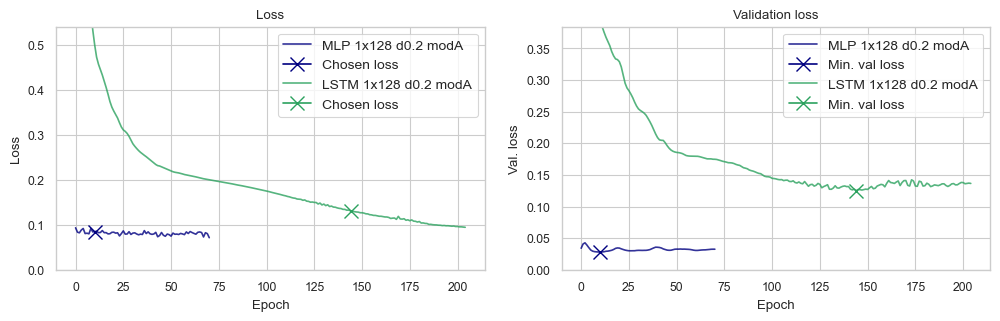

In [5]:
# Define whether to retrain models or not
retrain=False

maxEnrolWindow, indexColumn = mlModule.initModels(modelList, df_test)
mlModule.trainModels(modelList, filename, targetColumns, retrain)

# Predict

Model prediction scores
+-------------------------+-------------+------------+
|          Model          | Train score | Test score |
+-------------------------+-------------+------------+
|     Linear rCV modA     |    0.9938   |   0.934    |
|   MLP 1x128 d0.2 modA   |    0.9982   |   0.9181   |
|   LSTM 1x128 d0.2 modA  |    0.9401   |   0.2748   |
| MLP 1x128 + Linear modA |    0.9986   |   0.917    |
+-------------------------+-------------+------------+


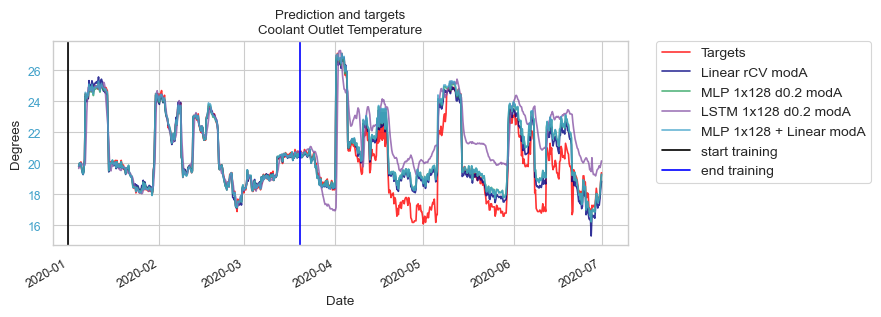

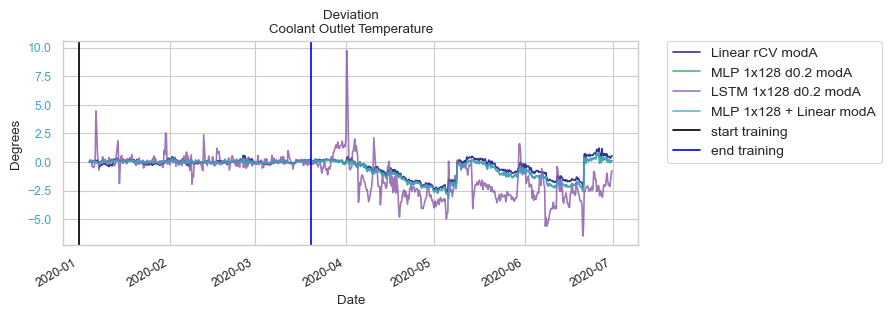

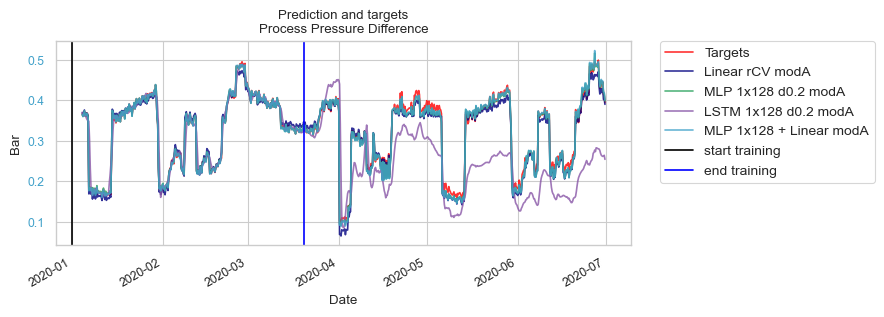

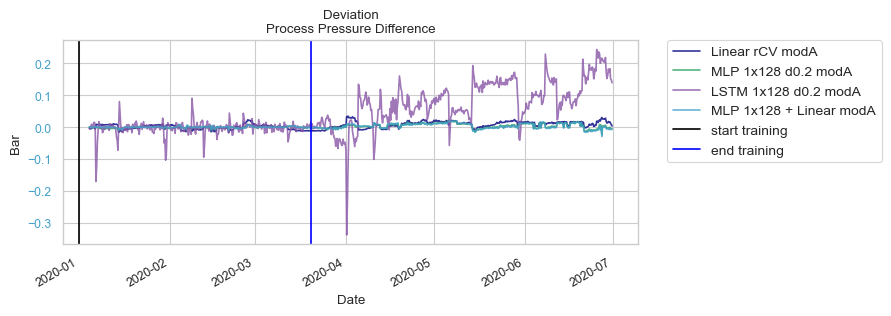

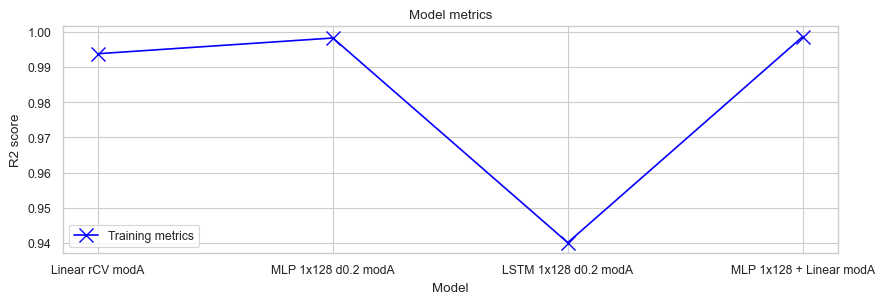

In [6]:
modelNames, metrics_train, metrics_test, columnsList, deviationsList = mlModule.predictWithModels(
    modelList,
    X_train,
    y_train,
    X_test,
    y_test,
    targetColumns,
    indexColumn,
    columnDescriptions,
    columnUnits,
    traintime,
    plot=True,
    interpol=False,
    score=True,
)